In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
import matplotlib.pyplot as plt

In [2]:
def butter_filter(data, cutoff, fs, btype='low', order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = lfilter(b, a, data, axis=0)
    return y

def notch_filter(signal, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return lfilter(b, a, signal, axis=0)

In [3]:
debug = False

# Setting up the board
if debug:
    # Create a synthetic board for debugging purposes
    board_id = BoardIds.SYNTHETIC_BOARD
    params = BrainFlowInputParams()
else:
    # Setting up the board
    params = BrainFlowInputParams()
    params.serial_number = 'UN-2023.02.30'
    board_id = BoardIds.UNICORN_BOARD
    
board = BoardShim(board_id, params)

# Getting specific board details
channels = board.get_eeg_channels(board_id) #EEG Channels
timestamp_channel = board.get_timestamp_channel(board_id) # Timestamp channel
marker_channel = board.get_marker_channel(board_id) # Marker channel for synchronization
sampling_rate = BoardShim.get_sampling_rate(board_id) # Hz

In [25]:
dataset = np.loadtxt(r"..//eeg_data.csv", delimiter=",")

FileNotFoundError: ..//eeg_data.csv not found.

In [5]:
eegdata = dataset[300:, channels]
eegdata.shape

(175675, 8)

In [6]:
# avg = np.mean(eegdata, axis = 1, keepdims=True)
# eegdata -= avg

In [24]:
for i in range(len(channels)):
    eegdata[:,i] = butter_filter(eegdata[:,i], 3, sampling_rate, 'high')
    # eegdata[:,i] = butter_filter(eegdata[:,i], 30, sampling_rate, 'low')
    eegdata[:,i] = notch_filter(eegdata[:,i], sampling_rate, freq=60)

    # mean = np.mean(eegdata[:, i])
    # std = np.std(eegdata[:, i])

    # eegdata[:, i] = (eegdata[:, i] - mean) / std

eegdata = eegdata[300:, :]

In [8]:
mean = np.mean(eegdata, axis=0, keepdims=True)
std = np.std(eegdata, axis=0, keepdims=True)

eegdata = (eegdata - mean) / std

In [9]:
markers = dataset[300:, marker_channel]

left = np.where(markers == 3)[0]
right = np.where(markers == 4)[0]
up = np.where(markers == 1)[0]
down = np.where(markers == 2)[0]
end = np.where(markers==67)[0]

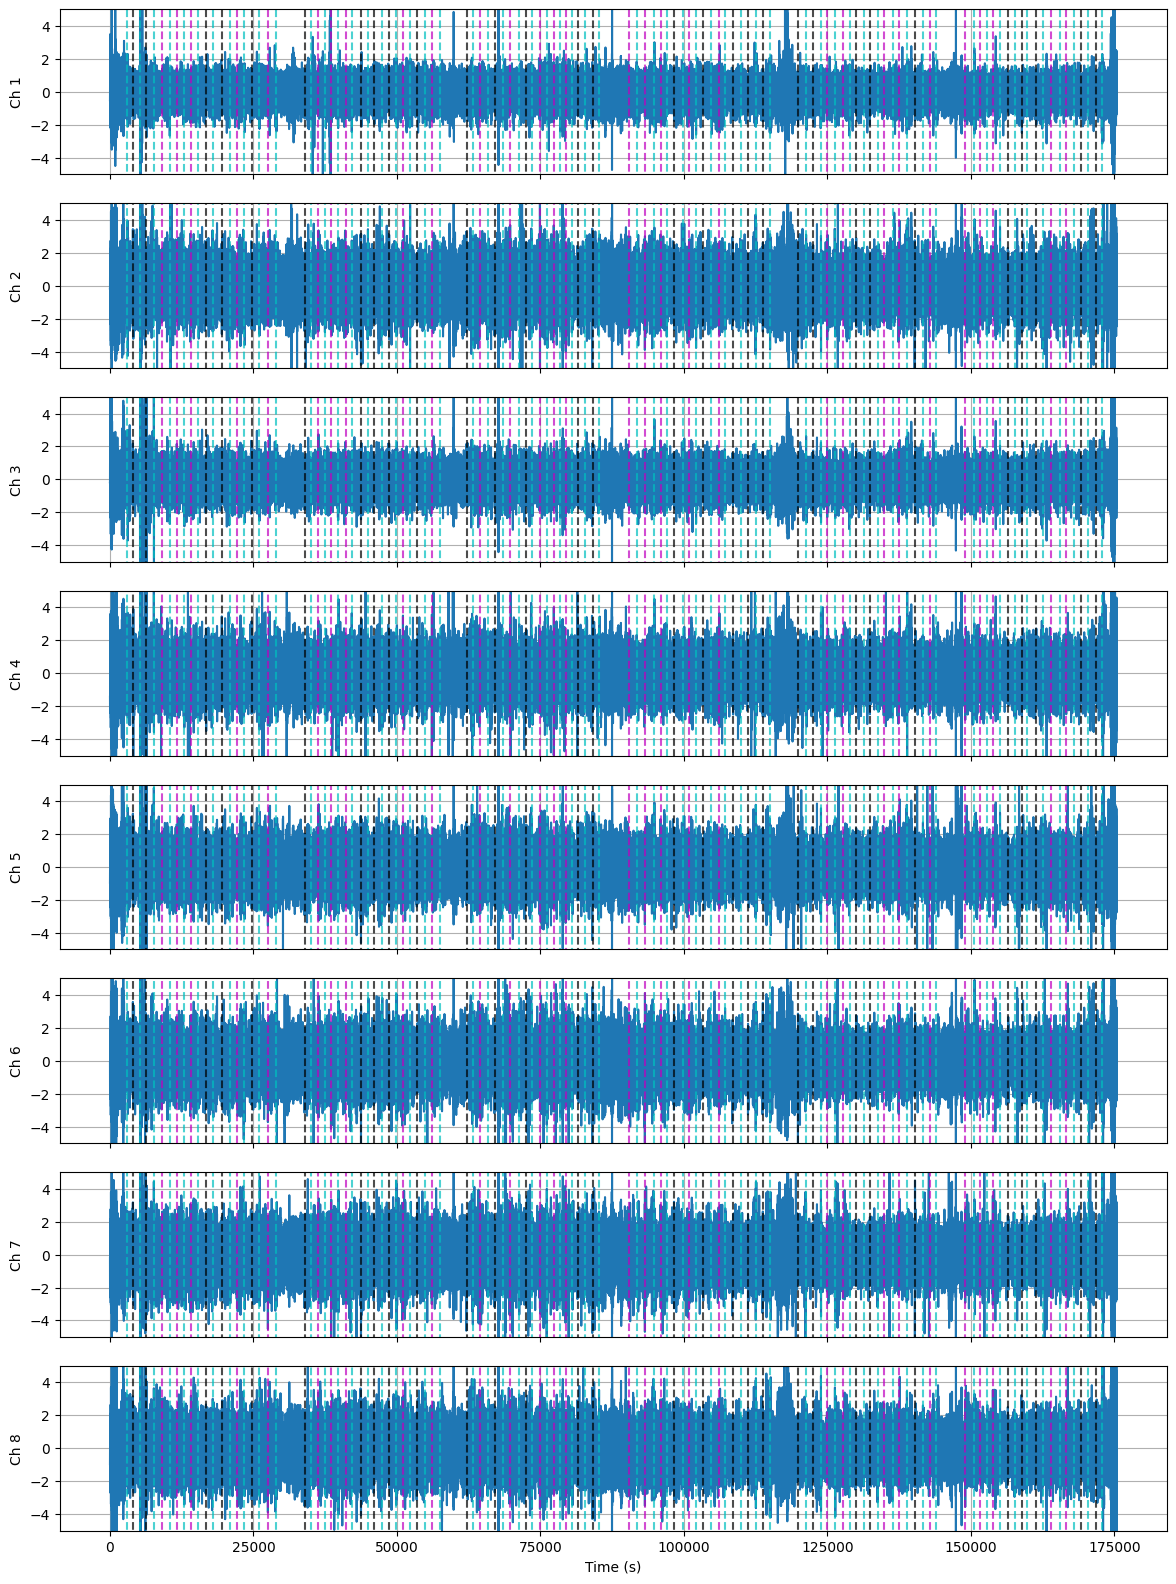

In [10]:
fig, axes = plt.subplots(len(channels), 1, figsize=(12, 2*len(channels)), sharex=True)

for i in range(len(channels)):
    axes[i].plot(eegdata[:, i])
    axes[i].set_ylabel(f"Ch {i+1}")
    axes[i].set_ylim(-5, 5)  # fix y-axis range if needed
    axes[i].grid(True)

    axes[i].vlines(left, ymin=-200, ymax=200, colors='r', linestyles='--', alpha=0.7)
    axes[i].vlines(right, ymin=-200, ymax=200, colors='g', linestyles='--', alpha=0.7)
    axes[i].vlines(up, ymin=-200, ymax=200, colors='k', linestyles='--', alpha=0.7)
    axes[i].vlines(down, ymin=-200, ymax=200, colors='m', linestyles='--', alpha=0.7)
    axes[i].vlines(end, ymin=-200, ymax=200, colors='c', linestyles='--', alpha=0.7)


axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [11]:
# Getting markers
idx_starting_markers = np.arange(0, len(markers))
idx_starting_markers = idx_starting_markers[markers != 0]
idx_starting_markers = idx_starting_markers[markers[idx_starting_markers] != 67]

idx_end_markers = np.arange(0, len(markers))[markers == 67]

# Preprocessing EEG
start = idx_end_markers[0]
idx_end_markers = idx_end_markers[1:]

raw_label = np.zeros_like(markers)

# Set label outputs to constant
for i in range(len(idx_starting_markers)):
    marker = markers[idx_starting_markers[i]]
    raw_label[idx_starting_markers[i]:idx_end_markers[i]] = marker


good_eeg = eegdata[start:, :]
good_label = raw_label[start:]

In [12]:
print(good_eeg.shape)
print(good_label.shape)

(172377, 8)
(172677,)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
num_classes = 4

val_idx = int(0.8*len(good_label))
test_idx = int(0.9*len(good_label))

X = {}
y = {}

X["Train"] = good_eeg[:val_idx]
y["Train"] = good_label[:val_idx]

X["Val"] = good_eeg[val_idx:test_idx]
y["Val"] = good_label[val_idx:test_idx]

X["Test"] = good_eeg[test_idx:]
y["Test"] = good_label[test_idx:]

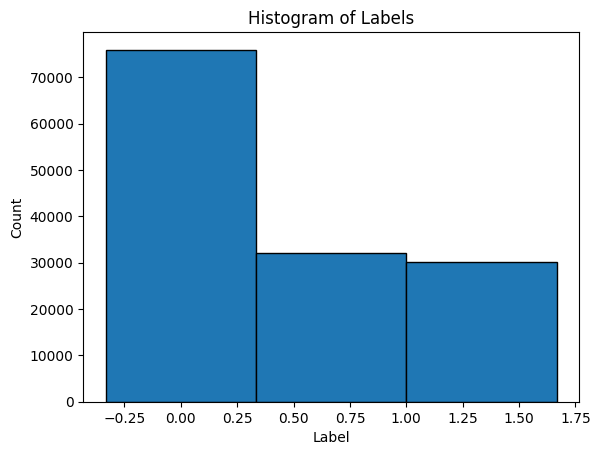

In [17]:
plt.hist(y["Train"], bins=len(set(y["Train"])), edgecolor='black', align='left')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Histogram of Labels")
plt.show()

In [18]:
classes, counts = np.unique(good_label, return_counts=True)
weights = 1.0 / counts   # inverse frequency
weights = weights / weights.sum()  # normalize (optional)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print(class_weights)  # e.g., tensor([0.25, 0.1667, 0.5])

tensor([0.1640, 0.4179, 0.4181], device='cuda:0')


In [19]:
window_size = int(4*sampling_rate)
step = 1

class EEGDataset(Dataset):
    def __init__(self, data_type):
        self.data_type = data_type
    
    def __len__(self):
        return len(X[self.data_type]) - window_size - step
    
    def __getitem__(self, idx):
        i = int(idx*step)

        # Get the EEG data and corresponding label
        eeg = torch.tensor(X[self.data_type][i:i+window_size, :], dtype=torch.float32)
        label = torch.tensor(y[self.data_type][i+window_size], dtype=torch.long)

        return eeg, label
    
train_dataset = EEGDataset("Train")
val_dataset = EEGDataset("Val")
test_dataset = EEGDataset("Test")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
# classifier
class EEGNet(nn.Module):
    def __init__(self, n_class, n_channels, total_samples, sampling_rate, F1 = 8, F2 = 16, D = 2):
        super(EEGNet, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=(1, sampling_rate//2),
                      padding="same", bias=False),
            nn.BatchNorm2d(num_features=F1),
            nn.Conv2d(in_channels=F1, groups=F1, out_channels=D*F1, kernel_size=(n_channels, 1), bias=False),
            nn.BatchNorm2d(num_features=D*F1),
            nn.ELU(),
            nn.AvgPool2d(kernel_size = (1, 4)),
            nn.Dropout(0.25)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=D*F1, groups=D*F1, out_channels=D*F1, kernel_size=(1, sampling_rate//8), 
                      padding="same", bias=False),
            nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=(1, 1), groups=1, bias = False),
            nn.BatchNorm2d(num_features=F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size = (1, 8)),
            nn.Dropout(0.25),
        )

        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = F2*(total_samples//32), out_features=n_class)
        )


    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        # print(x.shape)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        return x


In [22]:
model = EEGNet(3, 8, 1000, sampling_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # optimize all parameters
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(20):
    
    # Train the data
    model.train()
    running_loss = 0.0
    for inputs, label in train_loader:
        # Inputs are in shape (batch_size, channels, timepoints)
        # Need to transform to (batch_size, 1, channels, timepoints)
        inputs = inputs.unsqueeze(1).to(device)
        label = label.to(device)
        
        model_output = model(inputs)
        loss = criterion(model_output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validate Data
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for inputs, label in val_loader:
            # Inputs are in shape (batch_size, channels, timepoints)
            # Need to transform to (batch_size, 1, channels, timepoints)
            inputs = inputs.unsqueeze(1).to(device)
            label = label.to(device)
            
            model_output = model(inputs)
            pred = model_output.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(label.view_as(pred)).sum().item()

    # Print to see status
    print(f'Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Validation Acc: {val_acc/len(val_loader.dataset)}%')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1, Training Loss: 0.582743561043953, Validation Acc: 0.3103829839552468%
Epoch 2, Training Loss: 0.3151581716479067, Validation Acc: 0.2893588246142497%
Epoch 3, Training Loss: 0.24687406883109578, Validation Acc: 0.28345730620274173%
Epoch 4, Training Loss: 0.20963687799797956, Validation Acc: 0.4737812749738735%
Epoch 5, Training Loss: 0.18511138589747642, Validation Acc: 0.26550685436773835%
Epoch 6, Training Loss: 0.16840071251900102, Validation Acc: 0.2599741808569497%
Epoch 7, Training Loss: 0.15701176489934124, Validation Acc: 0.2680272945226532%
Epoch 8, Training Loss: 0.1473583555569576, Validation Acc: 0.23181902010204708%
Epoch 9, Training Loss: 0.13940673107233523, Validation Acc: 0.4241716358271347%


KeyboardInterrupt: 

(64,)
(128,)
(192,)
(256,)
(320,)
(384,)
(448,)
(512,)
(576,)
(640,)
(704,)
(768,)
(832,)
(896,)
(960,)
(1024,)
(1088,)
(1152,)
(1216,)
(1280,)
(1344,)
(1408,)
(1472,)
(1536,)
(1600,)
(1664,)
(1728,)
(1792,)
(1856,)
(1920,)
(1984,)
(2048,)
(2112,)
(2176,)
(2240,)
(2304,)
(2368,)
(2432,)
(2496,)
(2560,)
(2624,)
(2688,)
(2752,)
(2816,)
(2880,)
(2944,)
(3008,)
(3072,)
(3136,)
(3200,)
(3264,)
(3328,)
(3392,)
(3456,)
(3520,)
(3584,)
(3648,)
(3712,)
(3776,)
(3840,)
(3904,)
(3968,)
(4032,)
(4096,)
(4160,)
(4224,)
(4288,)
(4352,)
(4416,)
(4480,)
(4544,)
(4608,)
(4672,)
(4736,)
(4800,)
(4864,)
(4928,)
(4992,)
(5056,)
(5120,)
(5184,)
(5248,)
(5312,)
(5376,)
(5440,)
(5504,)
(5568,)
(5632,)
(5696,)
(5760,)
(5824,)
(5888,)
(5952,)
(6016,)
(6080,)
(6144,)
(6208,)
(6272,)
(6336,)
(6400,)
(6464,)
(6528,)
(6592,)
(6656,)
(6720,)
(6784,)
(6848,)
(6912,)
(6976,)
(7040,)
(7104,)
(7168,)
(7232,)
(7296,)
(7360,)
(7424,)
(7488,)
(7552,)
(7616,)
(7680,)
(7744,)
(7808,)
(7872,)
(7936,)
(8000,)
(8064,)
(8128,)


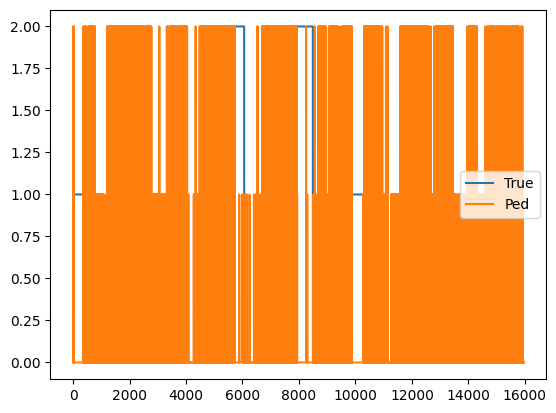

In [23]:
model.load_state_dict(best_model_wts)
# test
pred_list = []
true_list = []
flag = 0

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for eeg, labels in test_loader:
        eeg = eeg.unsqueeze(1).to(device)
        labels = labels.to(device)
        outputs = model(eeg)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions==labels).sum().item()

        if flag == 0:
            pred_list = predictions.cpu().detach().numpy()
            true_list = labels.cpu().detach().numpy()
            flag = 1
        else:
            pred = predictions.cpu().detach().numpy()
            true = labels.cpu().detach().numpy()

            print(pred_list.shape)
            pred_list = np.concatenate((pred_list, pred))
            true_list = np.concatenate((true_list, true))
        
    acc = 100 * (n_correct/n_samples)
    print(f'accuracy = {acc}')

    print(predictions)
    print(labels)


plt.plot(true_list, label="True")
plt.plot(pred_list, label="Ped")
plt.legend()